<a href="https://colab.research.google.com/github/HoBooom/2025_2_CV_study/blob/main/CIFAR_10_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR-10 로드

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision의 데이터셋의 output -> PIL_IMAGE [0,255]

-> ToTensor를 통해 [0, 1] 범위로 scaling

-> [-1,1] 범위로 정규화 진행

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), # 데이터를 tensor로 변환,이 과정에서
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]# 정규화 수행
)

batch_size = 4

# torchvision의 CIFAR-10데이터를 trainset에 저장
trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True, # 인터넷에서 데이터를 다운로드
                                        transform=transform) # 전처리를 위한 transform객체 적용

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2) # 데이터를 불러올 때 사용할 프로세스 개수

# 테스트데이터
testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

# class array define
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:01<00:00, 86.6MB/s]


* Unnormalize를 진행하는 이유 : 모델의 학습을 위해서 데이터를
[-1, 1]로 만들었지만,
이를 다시 출력하기 위해서는 [0, 1] or [0, 255]로 바꿔야하기 때문임.(생각해보면 당연한 내용, 음수일 수 없다!)

* Iterator를 사용하는 이유 : array는 이미 메모리를 사용하고 있기 때문에, 만약 데이터가 1억개라면 1억개의 데이터에 해당하는 메모리를 차지하고 있음, 그러나 Iterator를 사용하면 한번에 한개의 데이터만 메모리에 올리기 때문에 안전함



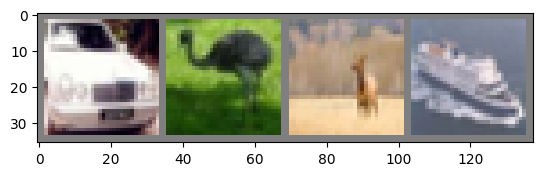

car  bird deer ship 


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img/2 + 0.5
  npimg = img.numpy() # Tensor -> Numpy
  # 차원 순서 변경
  # Pytorch : (Color Channel, Height, Width)
  # -> Matplotlib/Numpy : (Height, Width, Color Channel)
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

# iter(iterable)
# iterable -> array, dictionary : index, key를 통해 자유롭게 접근 가능
# iter : 상태, 데이터를 미리 만들지 않고 요청 시점에 생성, 오직 순차적으로(next)만 접근 가능, 뒤로 갈 수 없음, 끝까지 가면 소멸
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(''.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

딥러닝이 아닌 머신러닝 모델들을 주로 사용할 것이기 때문에 scikit-learn 사용

In [13]:
# 머신러닝 모델 라이브러리 임포트
import time
import pandas as pd
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [11]:
def load_data(data_train=None, data_test=None, train_test=1, scale=1, flatten=1):
  # data_train이 None이면 Keras 내장 CIFAR-10 데이터셋을 사용함
  if data_train == None:
    (X_train, y_train), (X_test, y_test) = cifar10.load_data() # CIFAR-10 데이터 로드
    y_train = y_train.flatten()
    y_test = y_test.flatten()

    # flatten == 1일때, 이미지를 1차원 벡터로 변환(ANN입력용)
    if flatten == 1:
      # (data 수, 32, 32, 3) -> (data 수, 32*32*3)
      X_train = X_train.reshape(-1, 32*32*3)
      X_test = X_test.reshape(-1, 32*32*3)

    # scale == 1일때 0~255 사이 픽셀값을 0~1사이로 정규화
    if scale == 1:
      X_train = X_train/255
      X_test = X_test/255
  # data_train에 파일 경로가 전달된 경우 (CSV파일 업로드)
  else:
      df_train = pd.read_csv(data_train)
      # 마지막 열(레이블)을 제외한 모든 데이터를 X_train으로 가져옴
      X_train = df_train.iloc[:, :len(df_train.columns) - 1].values
      y_train = df_train["label"].values

      # 테스트 데이터까지 함께 로드해야하는 경우
      if train_test == 1:
        if data_test == None:
          (x,y), (X_test, y_test) = cifar10.load_data()
          X_test = X_test / 255
          y_test = y_test.flatten()

          if flatten == 1:
            X_test = X_test.reshape(-1, 32*32*3)
        else:
          df_test = pd.read_csv(data_test)
          X_test = df_test.iloc[:, :len(df_test.columns) - 1].values
          y_test = df_test["label"].values
      # data를 2D, 3D image 형태로 복구해야하는 경우(CNN입력용)
      if flatten == 0:
        # HOG 특징 추출 데이터인 경우(흑백 32 * 32로 간주)
        if data_train == "../Data/train_aug_hog_cnn.csv" or data_train == "../Data/train_hog_cnn.csv":
          X_train = X_train.reshape(-1, 32, 32)
          X_test = X_test.reshape(-1, 32, 32)
        # 일반적인 RGB image인 경우 (32 * 32 * 3 형태로 복구)
        else:
          X_train = X_train.reshape(-1, 32, 32, 3)
          if X_test[0].shape != (32,32,3):
            X_test = X_test.reshape(-1, 32, 32, 3)

  # 학습 데이터만 필요한 경우(cross_val)
  if train_test == 0:
    return (X_train, y_train)
  return (X_train, X_test, y_train, y_test)


ROC 곡선은 FPR(False Positive Rate)이 변할때, TPR(True Positive Rate)이 어떻게 변하는 지를 나타낸 곡선,

직선에 가까울 수록 성능이 떨어지고, 멀어질 수록 성능이 뛰어남

AUC : ROC곡선의 밑의 면적 > 1에 가까울 수록 좋은 수치

In [14]:
def auc_roc(X, y, clf, clf_name, classes):
    # 각 클래스별 False Positive Rate(FPR)를 저장할 딕셔너리
    fpr = {}
    # 각 클래스별 True Positive Rate(TPR)를 저장할 딕셔너리
    tpr = {}
    # 임계값(Thresholds)을 저장할 딕셔너리
    thresh = {}
    # 계산된 AUC(곡선 아래 면적) 점수를 저장할 딕셔너리
    roc_auc = {}

    # 데이터에 존재하는 고유한 클래스 라벨 추출 (0~9)
    y_unique = np.unique(y)
    # ROC 계산을 위해 다중 클래스 라벨을 이진화(One-Hot 방식) 처리함
    y_predict_binarized = preprocessing.label_binarize(y, classes=y_unique)

    # 일반 머신러닝 모델(sklearn 등)인 경우
    if clf_name == None:
        # 각 클래스에 속할 확률값을 예측함 (predict_proba)
        predict_prob = clf.predict_proba(X)
    # 딥러닝 모델인 경우
    else:
        # 모델의 출력층(Softmax)에서 계산된 확률값을 가져옴
        predict_prob = clf.predict(X, verbose=0)

    # 그래프의 크기를 가로 10인치, 세로 8인치로 설정
    plt.rcParams['figure.figsize'] = (10, 8)

    # 각 클래스별로 순회하며 ROC 커브와 AUC를 계산
    for i in range(len(y_unique)):
        # roc_curve 함수를 통해 FPR, TPR을 계산함
        # y_predict_binarized[:, i]: i번째 클래스인지 여부(정답)
        # predict_prob[:, i]: i번째 클래스일 확률(예측값)
        fpr[i], tpr[i], thresh[i] = roc_curve(y_predict_binarized[:, i], predict_prob[:, i])

        # 계산된 FPR, TPR을 사용하여 곡선 아래 면적(AUC)을 계산
        roc_auc[i] = auc(fpr[i], tpr[i])
        # 해당 클래스에 대한 ROC 커브를 그래프에 그림
        # 레이블에는 클래스 이름과 AUC 점수를 소수점 둘째 자리까지 표시
        plt.plot(fpr[i], tpr[i], linestyle = '--', label = f'{classes[y_unique[i]]} Vs Rest (AUC {roc_auc[i]:.2f})')

    # 성능의 기준점이 되는 대각선(무작위 예측)을 파란색 점선으로 그림
    plt.plot([0, 1], [0, 1], 'b--')

    # x축과 y축의 범위를 0에서 1로 고정
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    # 그래프 제목 설정
    plt.title('Multiclass ROC curve')
    # x축 이름 설정 (위양성률)
    plt.xlabel('False Positive Rate')
    # y축 이름 설정 (진양성률)
    plt.ylabel('True Positive Rate')
    # 범례를 오른쪽 하단에 표시
    plt.legend(loc='lower right')
    # 최종 그래프 출력
    plt.show()

In [4]:
def model_evaluation(clf, y_train, train_predict, X_test, y_test, test_predict, training_time, clf_name=None):
  # CIFAR-10 데이터셋의 10개 클래스 이름을 리스트로 정의
  classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
  # 1. 정확도(Accuracy) 출력 섹션
  print(f'Accuracy Score: ')
  print('============================')
  # 학습 데이터에 대한 정확도 계산 및 출력 (0~1 사이 값을 %로 변환)
  print(f'Train Accuracy Score  : {accuracy_score(y_train, train_predict) * 100: .4f}%')
  # 테스트 데이터에 대한 정확도 계산 및 출력
  print(f'Test Accuracy Score   : {accuracy_score(y_test, test_predict) * 100: .4f}%')
  # 계산된 학습 소요 시간 출력
  print(f'Training Time         : {training_time: .4f}')
  # 2. 상세 분류 보고서(Classification Report) 출력
  # 정밀도(Precision), 재현율(Recall), F1-score 등을 클래스별로 보여줌
  print(f'\nClassification Report: ')
  print('============================')
  print(classification_report(y_test, test_predict, target_names=classes))

  # 3. 혼동 행렬(Confusion Matrix) 시각화 섹션
  print(f'\nConfusion Matrix: ')
  print('============================')
  # 실제 정답과 예측값을 비교하여 오차 행렬 생성
  cm = confusion_matrix(y_test, test_predict)
  # 혼동 행렬을 화면에 그리기 위한 객체 생성
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  # 그래프 크기 설정
  fig, ax = plt.subplots(figsize=(15, 15))

  # 그래프 제목 설정: 별도의 이름이 없으면 클래스 이름을 자동으로 가져옴
  if clf_name == None:
      ax.set_title(clf.__class__.__name__)
  else:
      ax.set_title(clf_name)

  # 혼동 행렬 그래프 출력
  disp.plot(ax=ax)
  plt.show()

  # 4. AUC-ROC 커브 시각화 함수 호출 (멀티 클래스 분류 성능 평가)
  auc_roc(X_test, test_predict, clf, clf_name, classes)

  # 5. 샘플 예측 결과 출력 (처음 10개 데이터)
  print(f'\nPredicted and Actual Test Set Results: ')
  print('========================================')
  # 인덱스 숫자로 되어 있는 정답과 예측값을 실제 클래스 이름 문자열로 변환
  first_10_actual = [classes[y_test[i]] for i in range(10)]
  first_10_pred = [classes[test_predict[i]] for i in range(10)]
  # 실제 정답과 모델이 예측한 값을 비교하여 출력
  print(f'Actual Results:', first_10_actual)
  print(f'Predicted Results:', first_10_pred)
  print()

In [5]:
def train_predict_ml(clf, data_train=None, data_test=None, scale=1):
  X_train, X_test, y_train, y_test = load_data(data_train, data_test, train_test=1, scale=scale)

  # 모델 학습 시작 시간 기록
  start_time = time.time()
  # 모델 학습 : 전달 받은 분류기(clf)를 학습 데이터로 훈련시킴 (ex : SVM, Random Forest)
  clf.fit(X_train, y_train)
  # 모델 종료 시간 기록
  end_time = time.time()
  training_time = end_time - start_time

  # 모델 예측 : 학습된 모델로 학습 데이터, 테스트 데이터의 결과값을 예측
  train_predict = clf.predict(X_train)
  test_predict = clf.predict(X_test)

  # 모델 평가함수 호출
  model_evaluation(clf, y_train, train_predict, X_test, y_test, test_predict, training_time)

In [6]:
def cross_validation(clf, data_train=None, scale=1):
    # load data
    X, y = load_data(data_train, train_test=0, scale=scale)

    # perform cross validation
    start_time = time.time()
    scores = cross_val_score(clf, X, y, cv=5)
    end_time = time.time()

    print("Model Accuracies:")
    print("Individual Accuracy:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("Training Time:", end_time - start_time)

    # model evaluation
    plt.plot(list(range(1, 6)), scores, label='Accuracy per Fold')
    plt.title("Model Accuracy")
    plt.xlabel("Model Run")
    plt.ylabel("Prediction Accuracy")

    average = [scores.mean()] * 5
    plt.plot(list(range(1, 6)), average, color='red', linewidth=1.0, linestyle='--', label='Average')
    plt.legend()
    plt.show()

ML_Model 1: Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy Score: 
Train Accuracy Score  :  42.5800%
Test Accuracy Score   :  40.2400%
Training Time         :  131.4365

Classification Report: 
              precision    recall  f1-score   support

    Airplane       0.42      0.48      0.45      1000
  Automobile       0.46      0.49      0.47      1000
        Bird       0.33      0.27      0.30      1000
         Cat       0.31      0.26      0.28      1000
        Deer       0.36      0.29      0.32      1000
         Dog       0.33      0.34      0.34      1000
        Frog       0.43      0.48      0.46      1000
       Horse       0.45      0.44      0.45      1000
        Ship       0.46      0.52      0.49      1000
       Truck       0.42      0.45      0.43      1000

    accuracy                           0.40     10000
   macro avg       0.40      0.40      0.40     10000
weighted avg       0.40      0.40      0.40     10000


Confusion Matrix: 


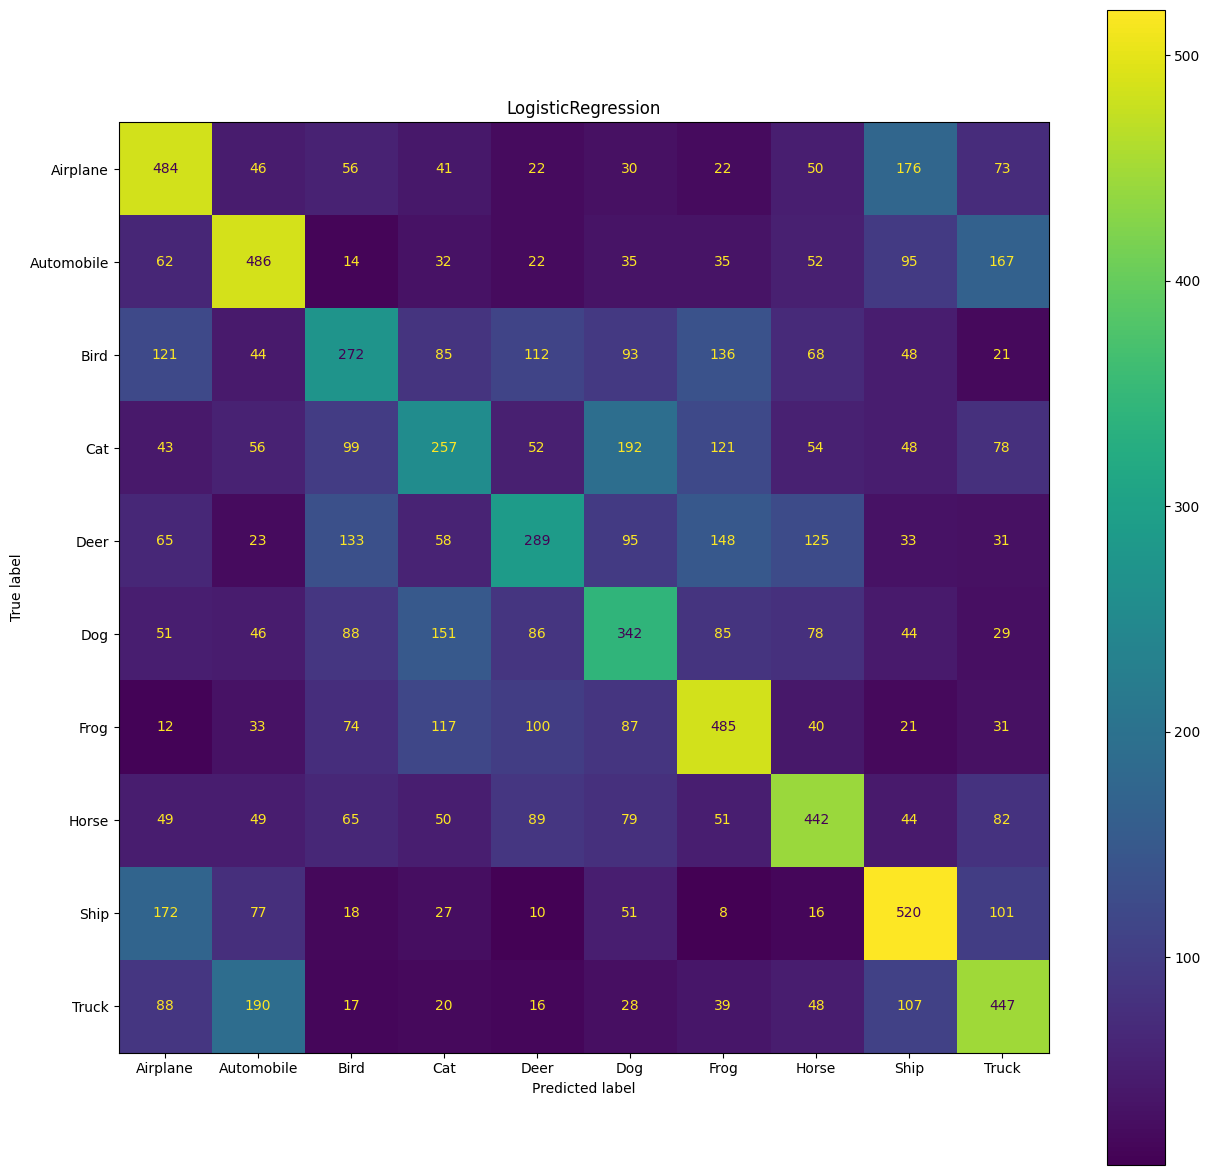

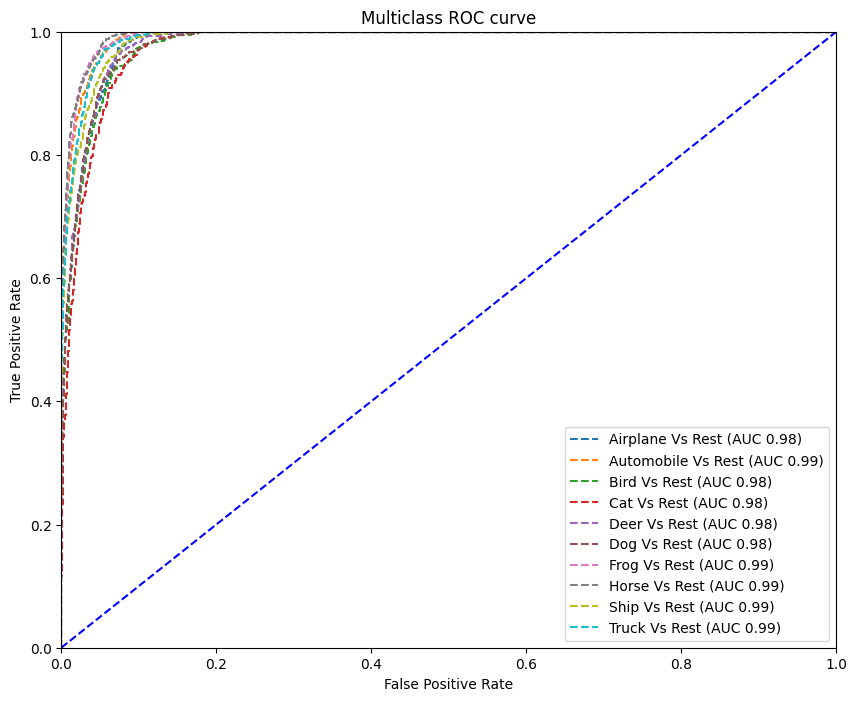


Predicted and Actual Test Set Results: 
Actual Results: ['Cat', 'Ship', 'Ship', 'Airplane', 'Frog', 'Frog', 'Automobile', 'Frog', 'Cat', 'Automobile']
Predicted Results: ['Cat', 'Truck', 'Ship', 'Ship', 'Deer', 'Frog', 'Cat', 'Frog', 'Dog', 'Automobile']



In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
train_predict_ml(lr, scale=0)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Model Accuracies:
Individual Accuracy: [0.4065 0.396  0.4115 0.4061 0.3971]
Mean: 0.40343999999999997
Standard Deviation: 0.005948983106380436
Training Time: 783.3738579750061


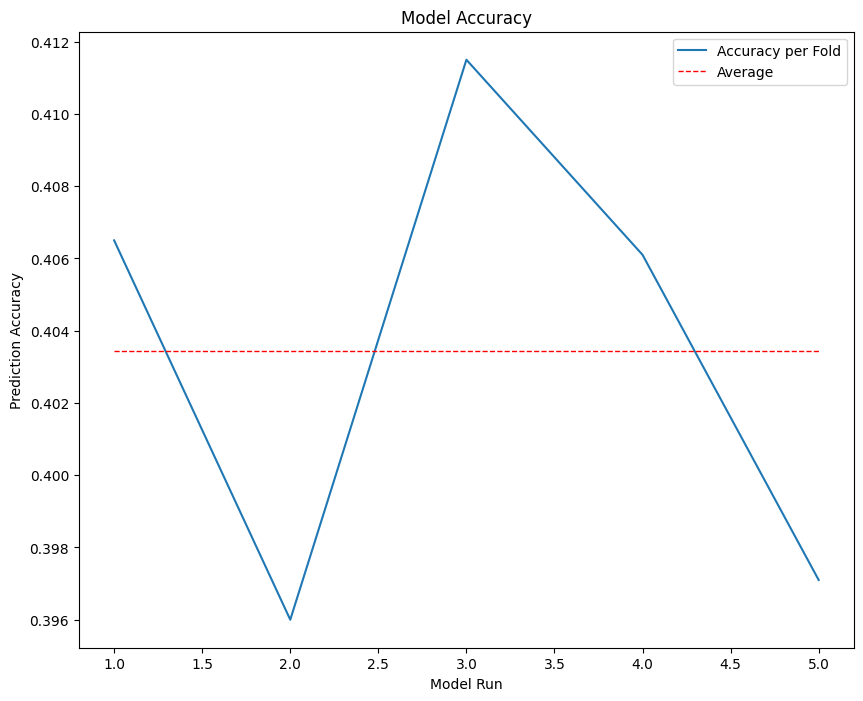

In [16]:
lr_cv = LogisticRegression(random_state=42)
cross_validation(lr_cv, scale=0)

Accuracy Score: 
Train Accuracy Score  :  28.4720%
Test Accuracy Score   :  29.7600%
Training Time         :  2.8283

Classification Report: 
              precision    recall  f1-score   support

    Airplane       0.27      0.49      0.35      1000
  Automobile       0.41      0.17      0.24      1000
        Bird       0.19      0.08      0.12      1000
         Cat       0.25      0.08      0.12      1000
        Deer       0.24      0.42      0.30      1000
         Dog       0.31      0.26      0.29      1000
        Frog       0.25      0.47      0.33      1000
       Horse       0.42      0.13      0.20      1000
        Ship       0.39      0.47      0.42      1000
       Truck       0.38      0.41      0.39      1000

    accuracy                           0.30     10000
   macro avg       0.31      0.30      0.28     10000
weighted avg       0.31      0.30      0.28     10000


Confusion Matrix: 


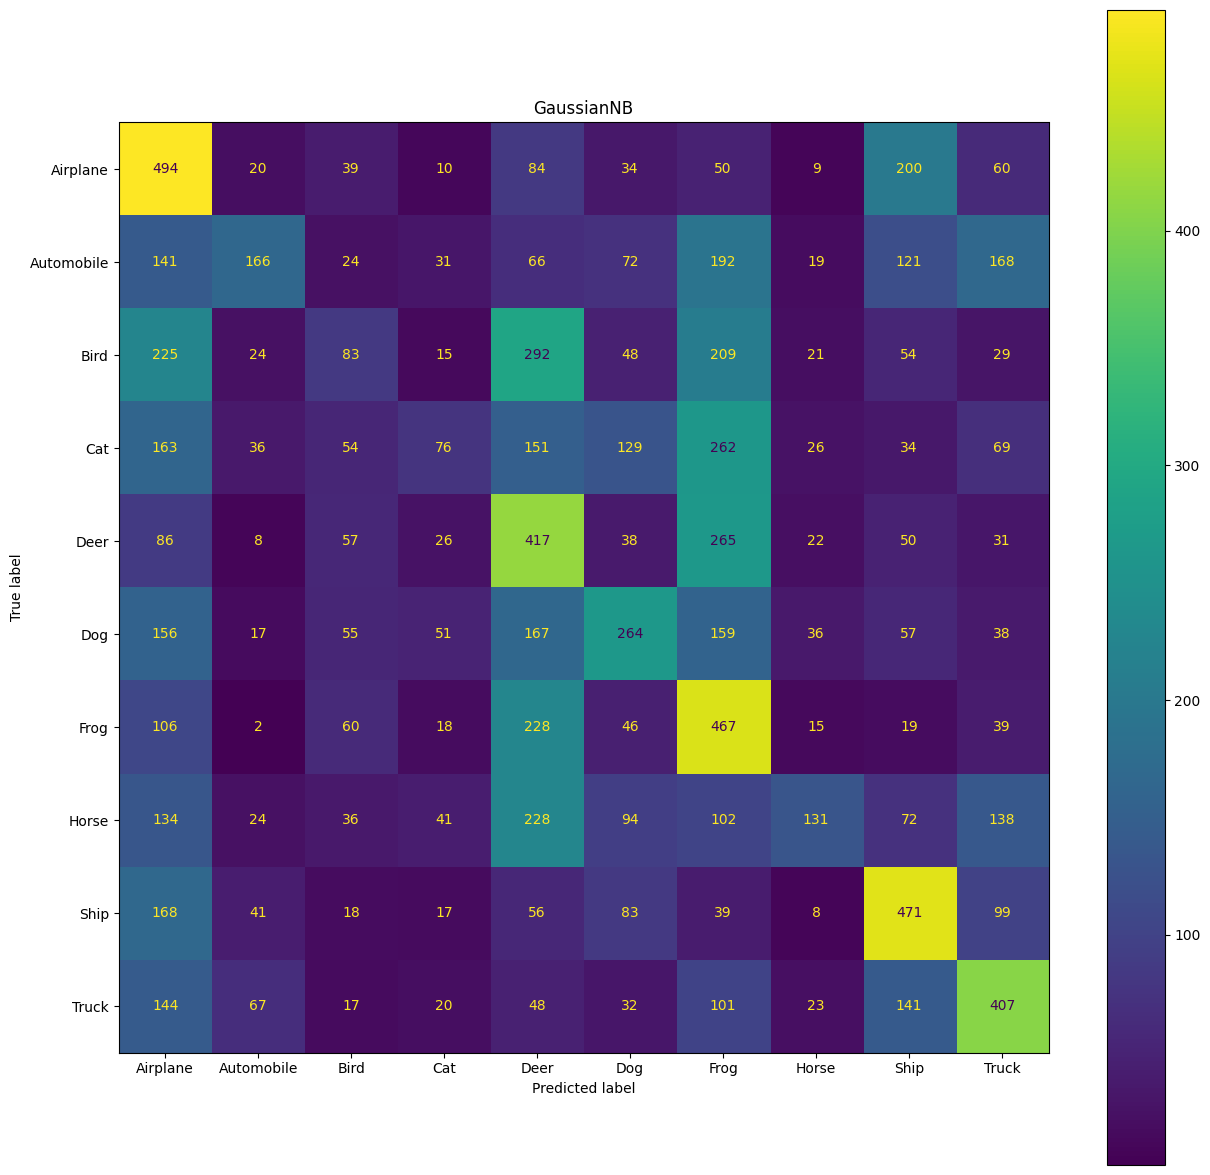

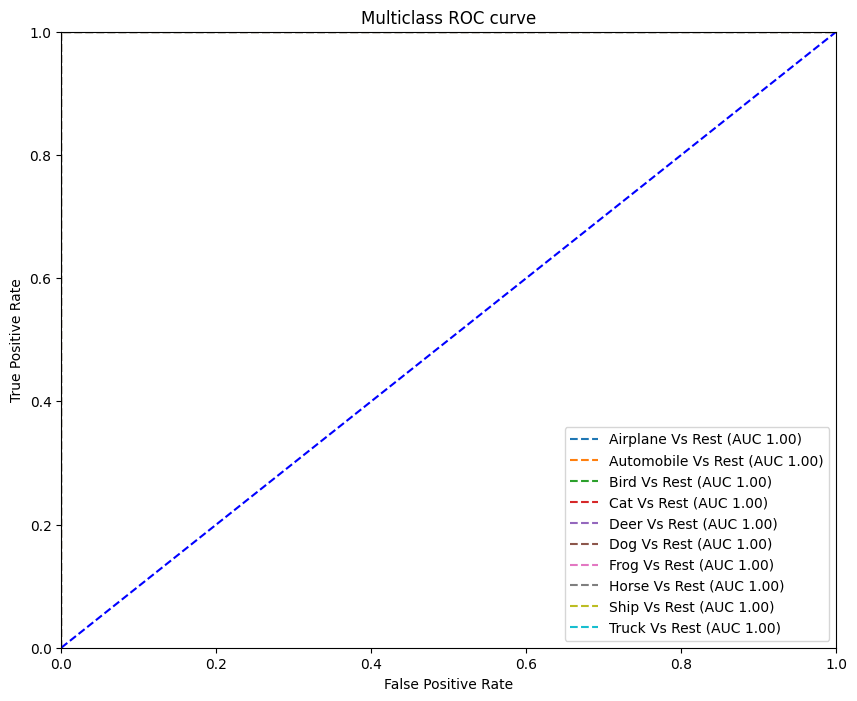


Predicted and Actual Test Set Results: 
Actual Results: ['Cat', 'Ship', 'Ship', 'Airplane', 'Frog', 'Frog', 'Automobile', 'Frog', 'Cat', 'Automobile']
Predicted Results: ['Frog', 'Ship', 'Ship', 'Ship', 'Deer', 'Frog', 'Cat', 'Frog', 'Airplane', 'Ship']



In [17]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
train_predict_ml(nb, scale=1)

Model Accuracies:
Individual Accuracy: [0.2889 0.2788 0.2885 0.2783 0.2866]
Mean: 0.28422000000000003
Standard Deviation: 0.0046969777517037485
Training Time: 27.7103009223938


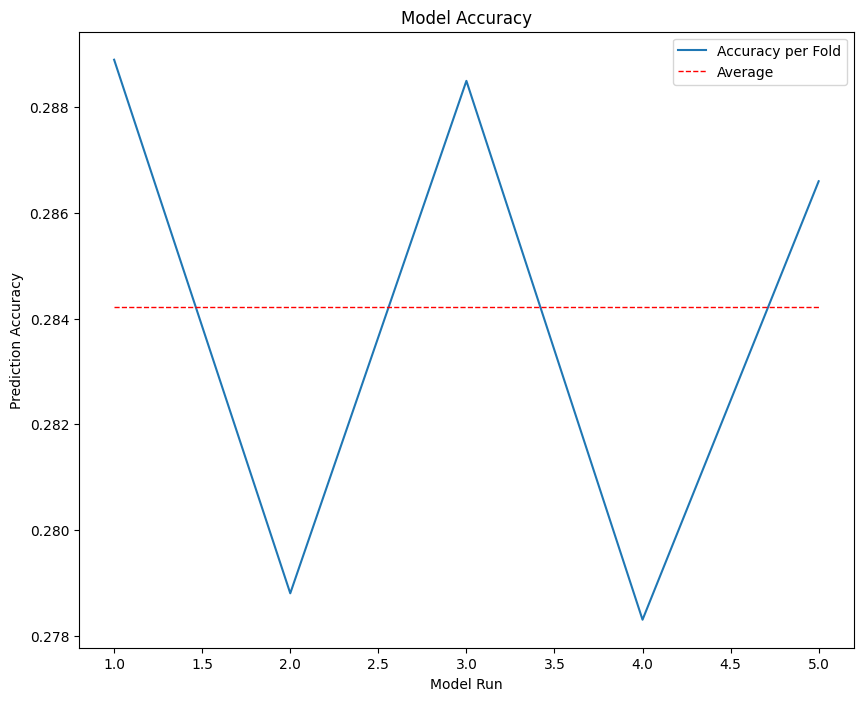

In [18]:
cross_validation(nb, scale=1)

Accuracy Score: 
Train Accuracy Score  :  50.5340%
Test Accuracy Score   :  33.9800%
Training Time         :  0.1252

Classification Report: 
              precision    recall  f1-score   support

    Airplane       0.38      0.54      0.45      1000
  Automobile       0.65      0.20      0.31      1000
        Bird       0.23      0.45      0.30      1000
         Cat       0.29      0.22      0.25      1000
        Deer       0.24      0.51      0.33      1000
         Dog       0.39      0.22      0.28      1000
        Frog       0.35      0.25      0.29      1000
       Horse       0.68      0.21      0.32      1000
        Ship       0.40      0.66      0.50      1000
       Truck       0.70      0.14      0.23      1000

    accuracy                           0.34     10000
   macro avg       0.43      0.34      0.33     10000
weighted avg       0.43      0.34      0.33     10000


Confusion Matrix: 


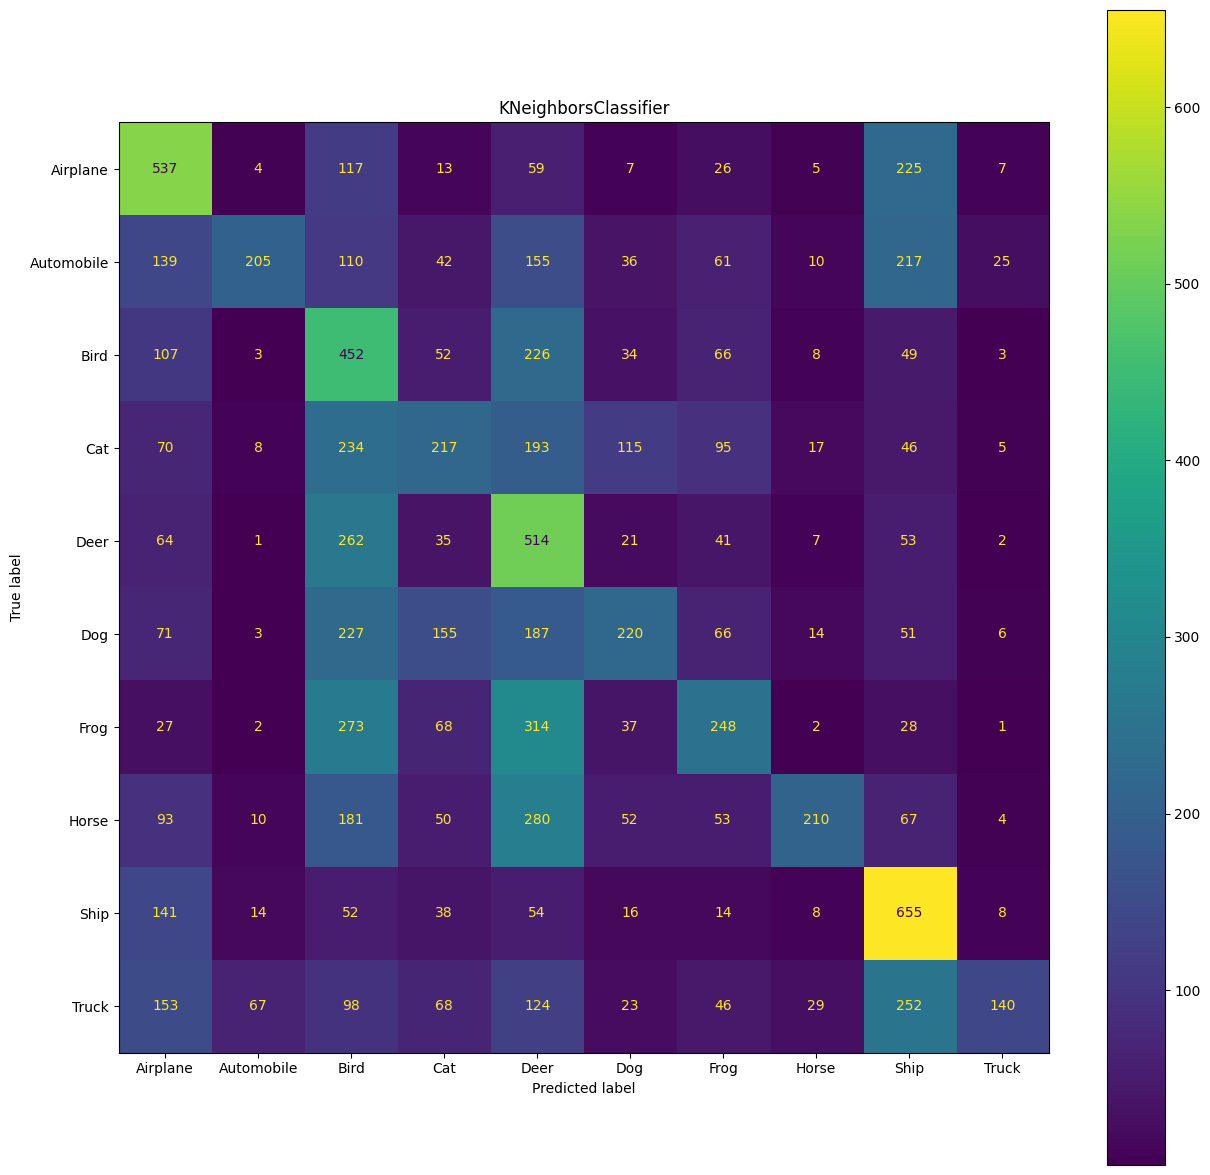

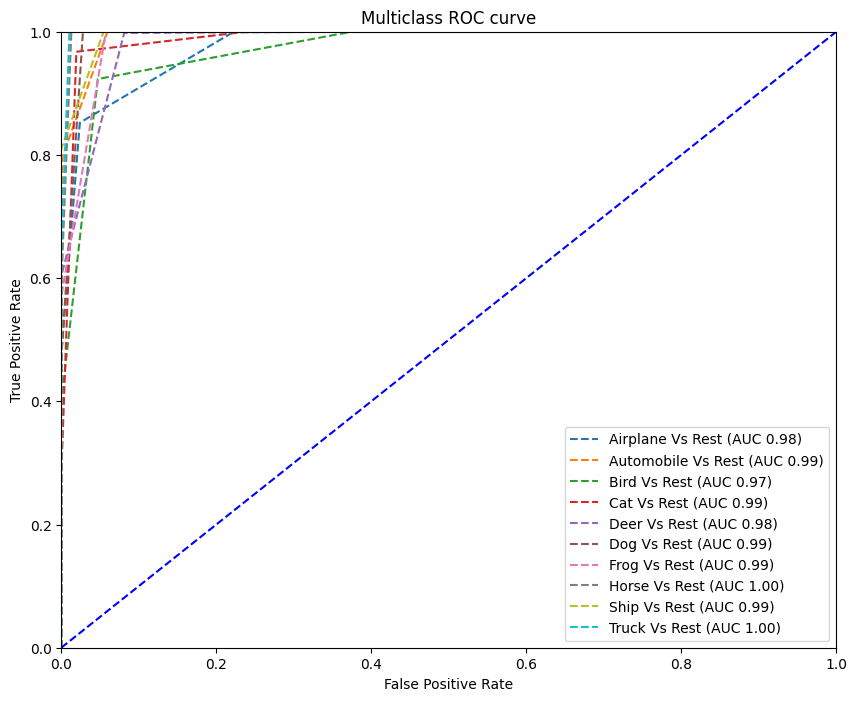


Predicted and Actual Test Set Results: 
Actual Results: ['Cat', 'Ship', 'Ship', 'Airplane', 'Frog', 'Frog', 'Automobile', 'Frog', 'Cat', 'Automobile']
Predicted Results: ['Bird', 'Ship', 'Ship', 'Airplane', 'Deer', 'Frog', 'Frog', 'Bird', 'Deer', 'Ship']



In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
train_predict_ml(knn, scale=0)

Model Accuracies:
Individual Accuracy: [0.3326 0.3286 0.337  0.3317 0.3304]
Mean: 0.33205999999999997
Standard Deviation: 0.0028125433329995154
Training Time: 466.8913879394531


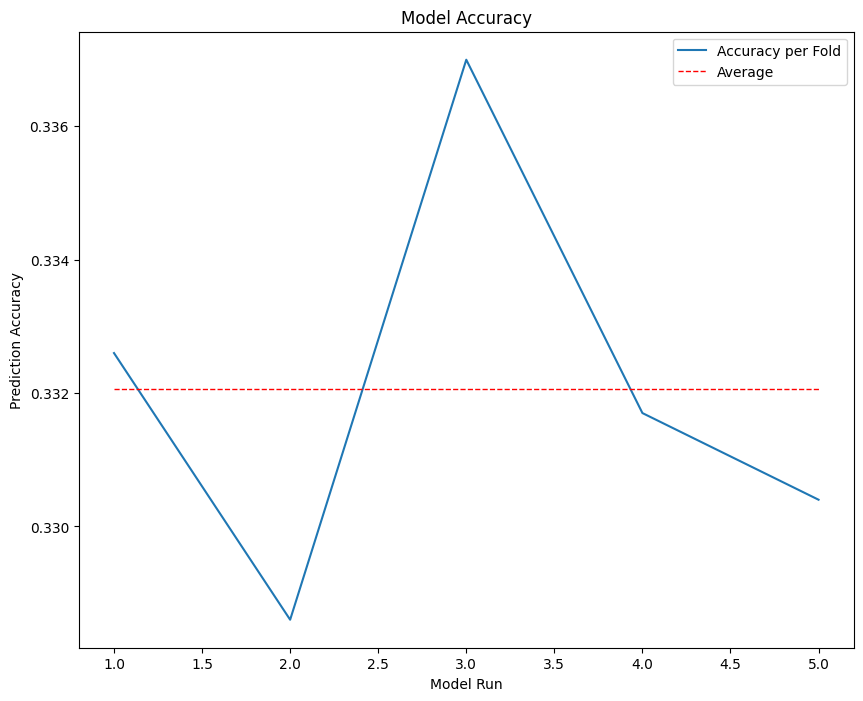

In [20]:
knn2 = KNeighborsClassifier()
cross_validation(knn2, scale=0)

In [ ]:
from sklearn import svm

svc=svm.SVC(random_state=42, probability=True)
train_predict_ml(svc, scale=0)

In [ ]:
cross_validation(svc, scale=0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
train_predict_ml(rf, scale=0)

In [ ]:
rf2 = RandomForestClassifier(random_state=42)
cross_validation(rf2, scale=0)